In [98]:
import numpy as np
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq #outputs half
from scipy.signal import find_peaks


# Useful Shorthand

In [101]:
'''Column names of limbs that we care about atm:
- STRN
- LASI
- LSHO 
- LELB 
- LFIN
- LWRA
- LWRB'''

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

coarseness = 20 #min: 5 

#Frequency plotting things
angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
limbLST = ['LSHO','LELB','LWRA','RSHO','RELB','RWRA'] # list of angles to loop through

# Load data

In [3]:
def np_piece_data_from_csv(num, piece, deriv=False):
    if deriv:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}_d.csv' #performance number 1-6
    else:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    mask = np.isnan(vals)
    vals[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), vals[~mask])

    return repo, vals

# Code duplicated from degrees2D.ipynb

In [4]:
def getDegrees2D(repo, vals, POINTSx): # duplicate in 'degrees2D.ipynb'
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    def unit_vector(vector):
        '''helper function to normalise vectors'''
        return normalize(vector, axis=1, norm='l2')

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

# Actual stuff

In [50]:
def standardize_len(lists: list[np.array]):
    '''standardize the length of the arrays by interpolation 
    (sort of stretching them performances to all be the same length for ease of comparison)'''
    x = np.linspace(0, len(lists[0]) - 1, len(lists[0]))
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) 
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)
    
def removeOutliers(y):
    # Calculate the IQR fences
    #print(f'{np.min(y)=} and {np.max(y)=}')
    x = np.linspace(np.min(y), np.max(y), num=len(y)) #set of x values that cover the range of the data and are sufficiently dense to capture any rapid changes in the y values. 
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Smooth the outliers with linear interpolation
    outliers = (y < lower_fence) | (y > upper_fence)
    x_outliers = x[outliers]
    f = interp1d(x[~outliers], y[~outliers], kind='linear', bounds_error=False, fill_value='extrapolate')
    y_smoothed = f(x_outliers)

    # Replace the outliers with the smoothed values
    y[outliers] = y_smoothed
    return(y)

def smooth(a, ker = 80):
    kernel_size = ker
    kernel = np.ones(kernel_size) / kernel_size
    a = np.convolve(a, kernel, mode='same') 
    a_cleaner = removeOutliers(a)
    return(a_cleaner)



def plot_fft(piece: int, perfs: list[int], limb: list[str], smoothker: int, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], DERIV: bool = False, save: bool = False) -> None:
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(111)

    fig2 = plt.figure(figsize=(10, 6))
    ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)

    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))
        ax1.plot(X, elem, label=perfs[count])
        ax2.plot(xf, np.abs(yf), label=perfs[count])

    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")
    ax1.legend()
    ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}')

    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Amplitude")
    ax2.legend()
    ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel}')
    ax2.set_xlim(xlim[0],xlim[1])
    ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

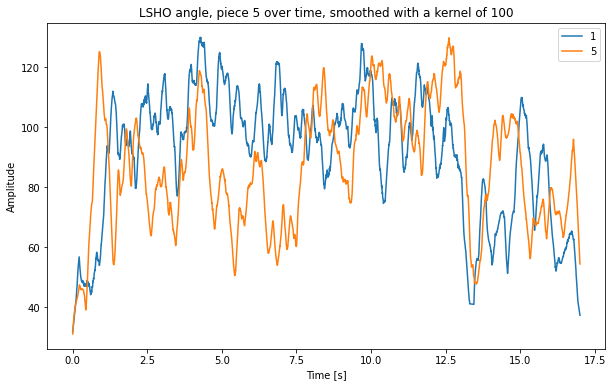

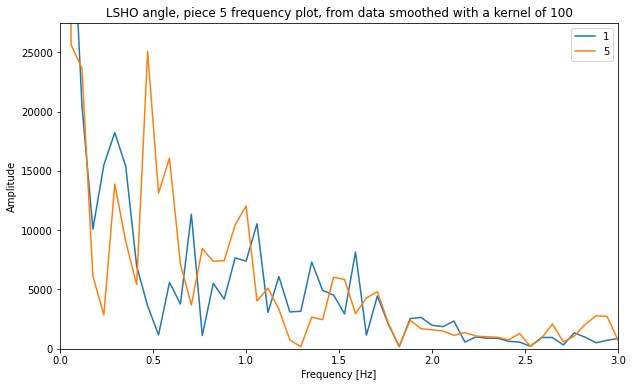

In [51]:
piece = 5 # can choose either multiple pieces or multiple performances for one angle
perfs = [1,5]
limb = ["LASI","LSHO","LELB"]
smoothkernel = 100
deriv = True

plot_fft(piece, perfs, limb, smoothkernel, DERIV = deriv)




# Find Peaks i.e. prominent frequencies

In [105]:
def plot_fft_w_peaks(piece: int, perfs: list[int], limb: list[str], smoothker: int, PROMINENCE: float = 0.5, WIDTH: float = 0.2, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], nonFFTplot = False, DERIV: bool = False, PLOT: bool = True, save: bool = False):
    if PLOT:
        if nonFFTplot:
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(111)

        fig2 = plt.figure(figsize=(10, 6))
        ax2 = fig2.add_subplot(111)

    angLST = []
    for perf in perfs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)
    peakLST = []
    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))

        # Find the peaks in the signal
        peaks, _ = find_peaks(np.abs(yf), prominence=PROMINENCE, width=WIDTH)
        if PLOT:
            if nonFFTplot: ax1.plot(X, elem, label=perfs[count])
            ax2.plot(xf, np.abs(yf), label=perfs[count])
            ax2.plot(xf[peaks], np.abs(yf)[peaks], "x")

        # add the index of the peaks, the x and the y values at which they occur to a list
        peakLST.append([peaks, xf[peaks], np.abs(yf)[peaks]])

    if PLOT:
        if nonFFTplot:
            ax1.set_xlabel("Time [s]")
            ax1.set_ylabel("Amplitude")
            ax1.legend()
            ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}, {DERIV=}')
        ax2.set_xlabel("Frequency [Hz]")
        ax2.set_ylabel("Amplitude")
        ax2.legend()
        ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel},  {DERIV=}')
        ax2.set_xlim(xlim[0],xlim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

    return(peakLST)

# Make sense with what we know? -> Yes

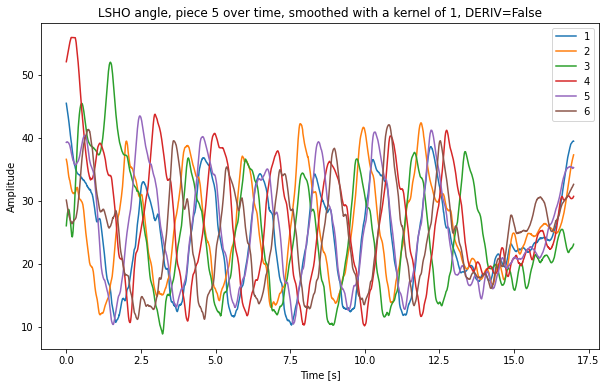

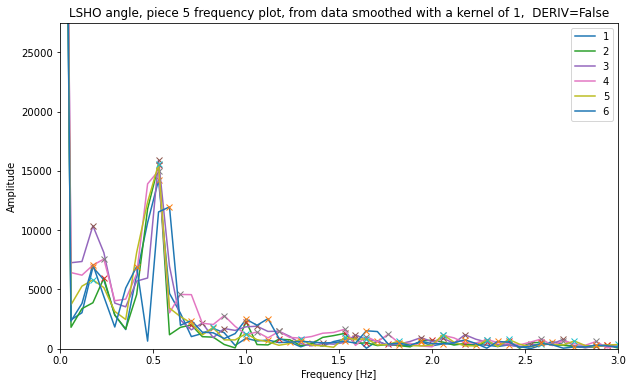

In [97]:
piece = 5 # can choose either multiple pieces or multiple performances for one angle
perfs = [1,2,3,4,5,6]
limb = ["LASI","LSHO","LELB"]

smoothkernel = 1
p = 1
w = 0.5
p = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, nonFFTplot=True, PROMINENCE = p, WIDTH = w)


# To deriv or not to deriv? -> Not to deriv

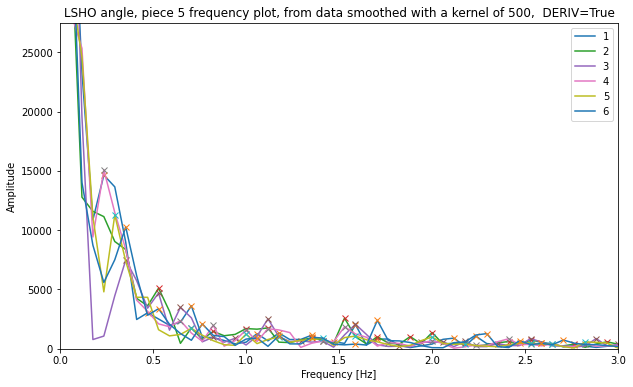

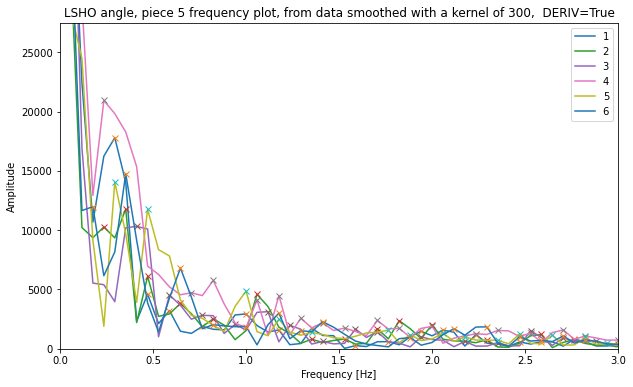

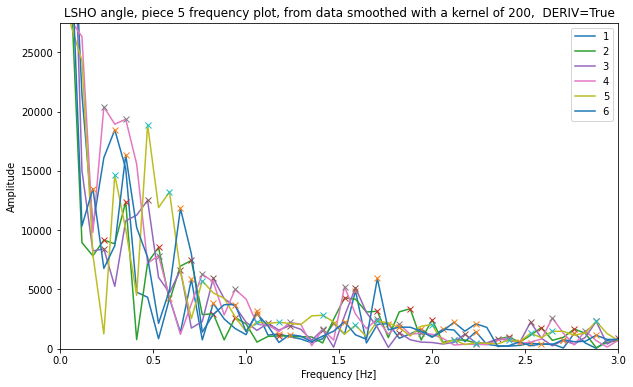

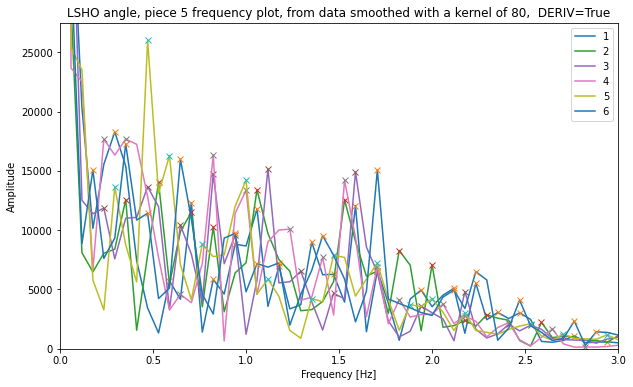

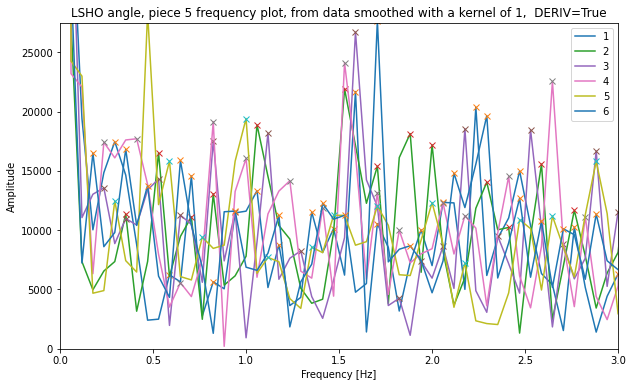

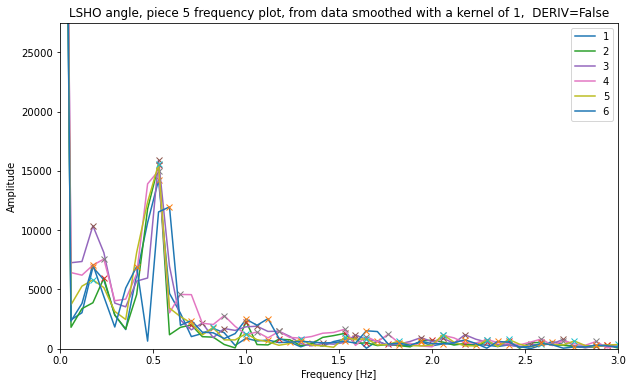

In [99]:
piece = 5 # can choose either multiple pieces or multiple performances for one angle
perfs = [1,2,3,4,5,6]
limb = ["LASI","LSHO","LELB"]

smoothkernel = 500
d = True
p = 1
w = 0.5
peaks_ker500 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)
smoothkernel = 300
peaks_ker300 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)
smoothkernel = 200
peaks_ker200 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)
smoothkernel = 80
peaks_ker80 = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)
smoothkernel = 1
peaks_noKer = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)



smoothkernel = 1
d = False
p = 1
w = 0.5
peaks_noDeriv = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)


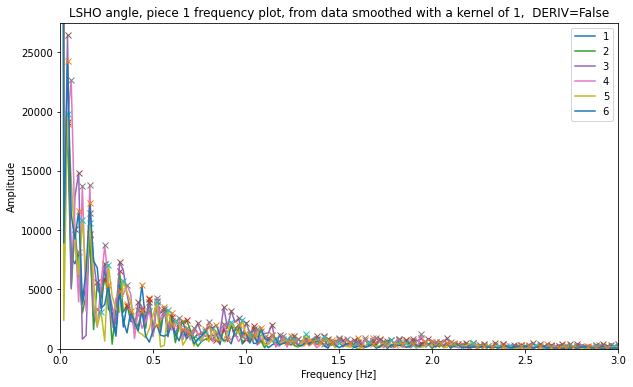

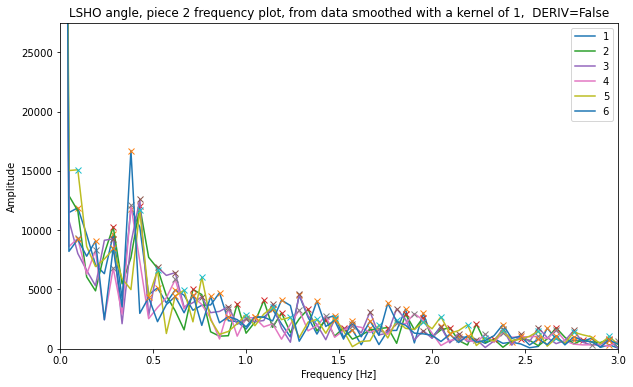

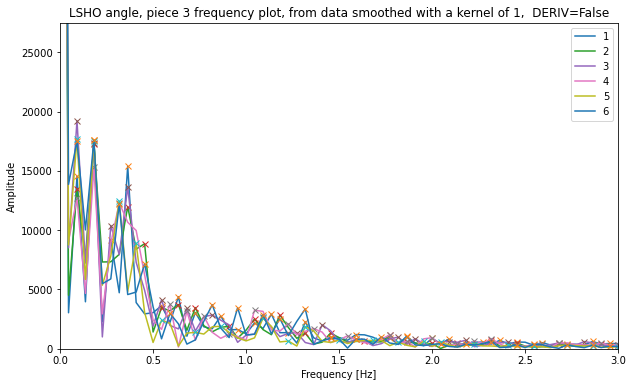

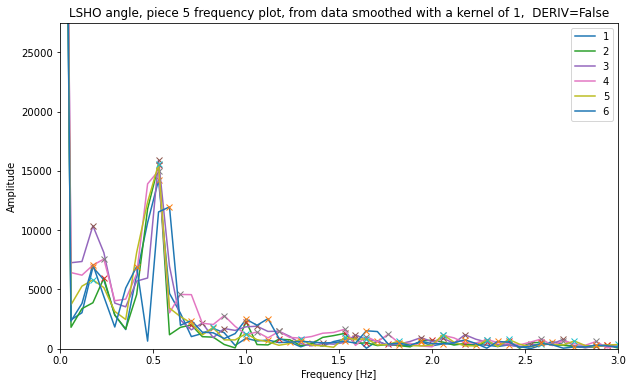

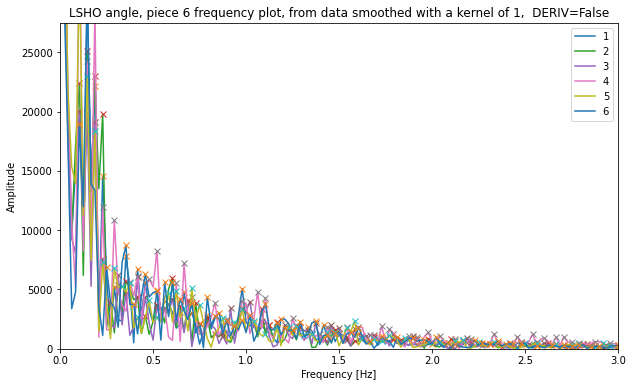

In [100]:
perfs = [1,2,3,4,5,6]
limb = ["LASI","LSHO","LELB"]

smoothkernel = 1
d = False
p = 1
w = 0.5
for piece in [1,2,3,5,6]:
    peaks_noDeriv = plot_fft_w_peaks(piece, perfs, limb, smoothkernel, PROMINENCE = p, WIDTH = w, DERIV = d)


In [90]:










print(len(peaks_noDeriv[0][0]),
      len(peaks_ker500[0][0]),
      len(peaks_ker300[0][0]),
      len(peaks_ker200[0][0]),
      len(peaks_ker80[0][0]),
      len(peaks_noKer[0][0]))


424 461 511 548 593 633


# How many peaks do we want?

In [ ]:
def plot_fft_in_progress(piece: int, perf: int, limbs: list[list[str]], smoothker: int, PROMINENCE: float = 0.5, WIDTH: float = 0.2, xlim: list[int] = [0,3], ylim: list[int] = [0,27500], nonFFTplot = False, DERIV: bool = False, save: bool = False):
    if nonFFTplot:
        fig1 = plt.figure(figsize=(10, 6))
        ax1 = fig1.add_subplot(111)

    fig2 = plt.figure(figsize=(10, 6))
    ax2 = fig2.add_subplot(111)

    angLST = []
    for limb in limbs:
        repo,vals = np_piece_data_from_csv(perf,piece,deriv=DERIV)
        ang = smooth(getDegrees2D(repo, vals, POINTSx = limb), ker=smoothker)
        angLST.append(ang)

    stand_len_angLST = standardize_len(angLST)
    peakLST = []
    for count,elem in enumerate(stand_len_angLST):
        labl = f'{limb[1]}_perf{elem}'
        ln=np.size(elem,0)
        X = np.linspace(0, ln//240, ln) 
        N = np.size(X)
        yf = rfft(elem)
        xf = rfftfreq(N, 1/(sr := 240))

        # Find the peaks in the signal
        peaks, _ = find_peaks(np.abs(yf), prominence=PROMINENCE, width=WIDTH)

        if nonFFTplot: ax1.plot(X, elem, label=perfs[count])
        ax2.plot(xf, np.abs(yf), label=perfs[count])
        ax2.plot(xf[peaks], np.abs(yf)[peaks], "x")

        # add the index of the peaks, the x and the y values at which they occur to a list
        peakLST.append([peaks, xf[peaks], np.abs(yf)[peaks]])

    if nonFFTplot:
        ax1.set_xlabel("Time [s]")
        ax1.set_ylabel("Amplitude")
        ax1.legend()
        ax1.set_title(f'{limb[1]} angle, piece {piece} over time, smoothed with a kernel of {smoothkernel}, {DERIV=}')
    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("Amplitude")
    ax2.legend()
    ax2.set_title(f'{limb[1]} angle, piece {piece} frequency plot, from data smoothed with a kernel of {smoothkernel},  {DERIV=}')
    ax2.set_xlim(xlim[0],xlim[1])
    ax2.set_ylim(ylim[0],ylim[1])

    if save:
        plt.savefig(f'visuals/frequencies_piece{piece}.png')

    return(peakLST)

In [197]:
import pandas as pd

def correlation_calcs(angles : list[list[str]], save: bool = False, filename: str = 'corr_matrix'):
    xpeak_dict = {}
    ypeak_dict = {}

    d = False
    p = 1
    w = 0.5
    for i in [1,2,3,4,5,6]: #perf
        for j in [1,2,3,5,6]: #pieces
            for k in angles:
                piece,perf,limb = j,[i],k
                peaks = plot_fft_w_peaks(piece, perf, limb, smoothker=1, PROMINENCE = p, WIDTH = w, DERIV = d, PLOT=False)
                xpeak_dict[f'x{i}{j}{k[1]}'] = peaks[0][1]
                ypeak_dict[f'y{i}{j}{k[1]}'] = peaks[0][2]

    xdf = pd.DataFrame({u: pd.Series(v) for u, v in xpeak_dict.items()}).fillna(np.nan)
    ydf = pd.DataFrame({u: pd.Series(v) for u, v in ypeak_dict.items()}).fillna(np.nan)

    # Run correlation funcs
    xcorr_matrix = xdf.corr()
    ycorr_matrix = ydf.corr()

    if save:
        xcorr_matrix.to_csv(f'x{filename}.csv')
        ycorr_matrix.to_csv(f'y{filename}.csv')
    return(xcorr_matrix,ycorr_matrix)

def correlation_plots_s(corr_matrix: pd.DataFrame, TITLE: str = "Average correlations in fft peak heights for all limbs", LEGEND = ''):

    # Select subset of DataFrame where rows and columns start with "x{perf}{piece}"
    plt.figure(figsize=(18, 5))
    for perf in [1,2,3,4,5,6]: #perf
        for piece in [1,2,3,5,6]: #pieces
            y1_subsetCol = corr_matrix.filter(regex=f"^y{perf}{piece}")
            y1_subset = y1_subsetCol.loc[corr_matrix.index.str.match(f'^y{perf}{piece}')]

            # Compute average across all entries in subset
            x = f'{perf=}, {piece=}'
            y1_mean = y1_subset.mean().mean()
            plt.bar(x, y1_mean, color="black")
    plt.bar(x, y1_mean, color="black", label = LEGEND)
    plt.title(TITLE)
    plt.xlabel('Category')
    plt.xticks(rotation=45)
    plt.ylabel('Correlation Value')
    plt.legend()
    plt.ylim(0.7,1)
    plt.show()

In [167]:
#ydf = pd.read_csv("ycorr_matrix.csv")
angLST = [angLSHO, angLELB, angLWRA, angRSHO, angRELB, angRWRA]
Lycorr_matrix = correlation_calcs(angLST[:3], save=True)[1]
Rycorr_matrix = correlation_calcs(angLST[3:], save=True)[1]

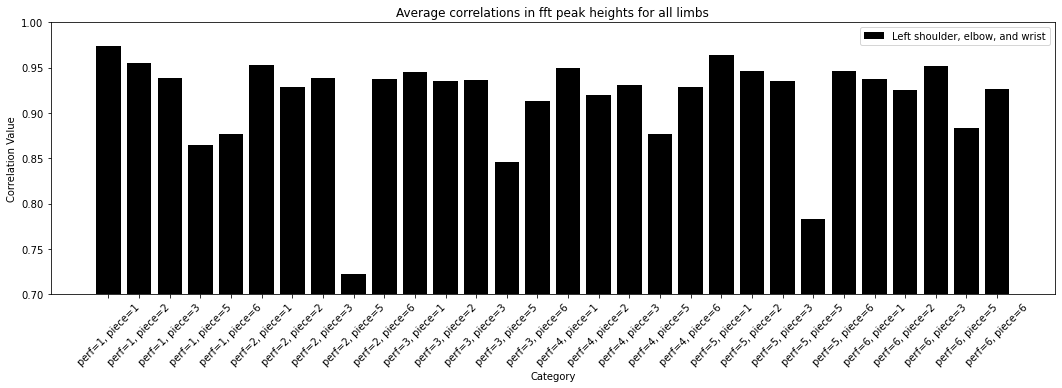

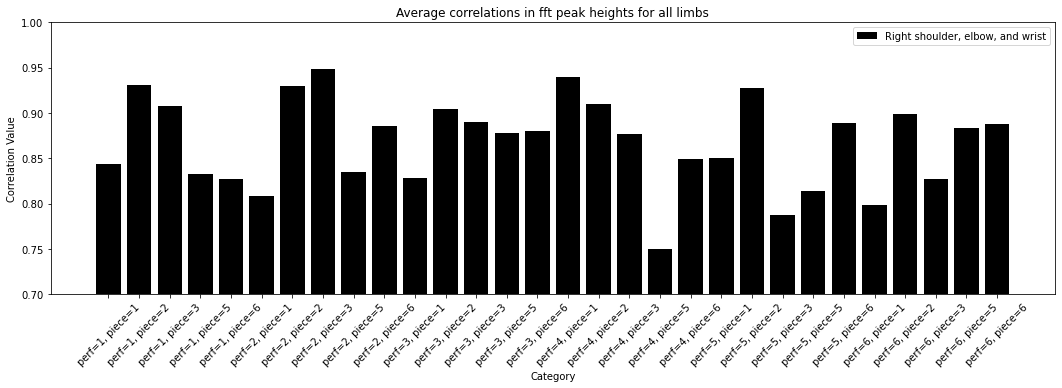

In [198]:
correlation_plots_s(Lycorr_matrix, LEGEND = 'Left shoulder, elbow, and wrist')
correlation_plots_s(Rycorr_matrix, LEGEND = 'Right shoulder, elbow, and wrist')

In [195]:
def correlation_plots_m(corr_matrices: list[pd.DataFrame], LEGENDS: list[str], COLORS: list[str], TITLE: str = "Average correlations in fft peak heights for all limbs"):

    # Select subset of DataFrame where rows and columns start with "x{perf}{piece}"
    plt.figure(figsize=(18, 5))
    for count, corr_matrix in enumerate(corr_matrices):
        for perf in [1,2,3,4,5,6]: #perf
            for piece in [1,2,3,5,6]: #pieces
                y1_subsetCol = corr_matrix.filter(regex=f'^y{perf}{piece}')
                y1_subset = y1_subsetCol.loc[corr_matrix.index.str.match(f'^y{perf}{piece}')]


                # Compute average across all entries in subset
                x = f'{perf=}, {piece=}'
                y1_mean = y1_subset.mean().mean()
                plt.bar(x, y1_mean, color=COLORS[count])
        plt.bar(x, y1_mean, color=COLORS[count], label = LEGENDS[count])
    plt.title(TITLE)
    plt.xlabel('Category')
    plt.xticks(rotation=45)
    plt.ylabel('Correlation Value')
    plt.legend()
    plt.ylim(0.7,1)
    plt.show()

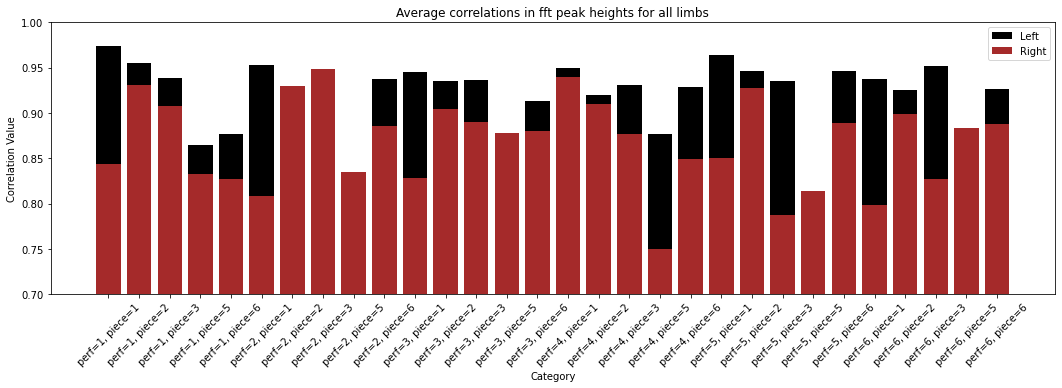

In [196]:
correlation_plots_m([Lycorr_matrix,Rycorr_matrix], LEGENDS = ['Left','Right'], COLORS = ['black','brown'])


## By Performance

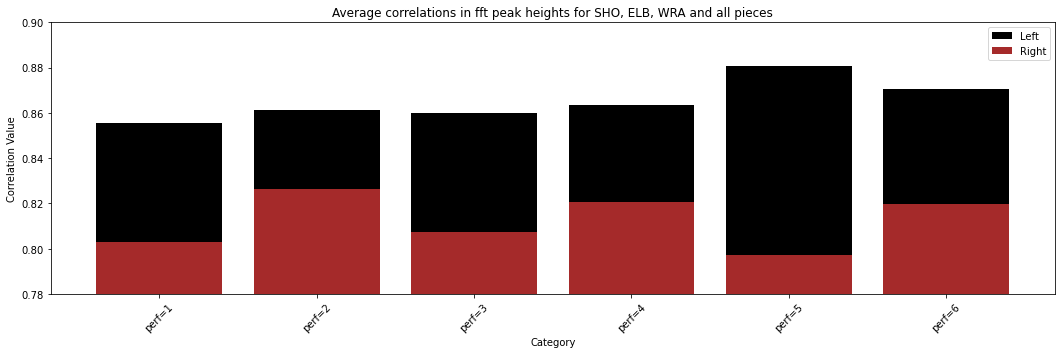

In [191]:
plt.figure(figsize=(18, 5))
for perf in [1,2,3,4,5,6]: #perf
    Ly1_subsetCol = Lycorr_matrix.filter(regex=f'^y{perf}')
    Ly1_subset = Ly1_subsetCol.loc[Lycorr_matrix.index.str.match(f'^y{perf}')]
    Ry1_subsetCol = Rycorr_matrix.filter(regex=f'^y{perf}')
    Ry1_subset = Ry1_subsetCol.loc[Rycorr_matrix.index.str.match(f'^y{perf}')]

    # Compute average across all entries in subset
    x = f'{perf=}'
    Ly1_mean = Ly1_subset.mean().mean()
    Ry1_mean = Ry1_subset.mean().mean()
    plt.bar(x,Ly1_mean, color="black")
    plt.bar(x,Ry1_mean, color="brown")
plt.bar(x,Ly1_mean, color="black", label="Left")
plt.bar(x,Ry1_mean, color="brown", label="Right")
plt.title("Average correlations in fft peak heights for SHO, ELB, WRA and all pieces")
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Correlation Value')
plt.legend()
plt.ylim(0.78,0.90)
plt.show()

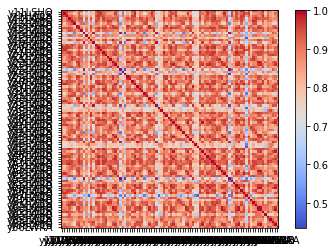

In [172]:
# Create heatmap of correlation matrix
corr_matrix = Lycorr_matrix
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.colorbar()
plt.show()

## Frechet Distance

## PCA

[-0.24227188 -0.07817291 -0.25889303 -0.18690538 -0.24349409 -0.27234024
  0.09644758 -0.08383828 -0.15309202  0.7236695  -0.07417356  0.49144165
  0.03869935  0.51103447 -0.26811115]
[-0.16774648 -0.01845099 -0.09527042  0.02792043 -0.14988484 -0.14420817
  0.09299575  0.03311695 -0.18258883  0.7733767  -0.0295758  -0.03443638
 -0.01118184  0.1341727  -0.22823882]
[-0.11853657 -0.18980039 -0.1856532  -0.11608712  0.33690391  0.05209304
 -0.18910153  0.01525525 -0.10870737 -0.11134626  0.49056753  0.23344134
 -0.14287531 -0.14384596  0.17769265]
[-0.21605654  0.03541729 -0.20538292 -0.07322367 -0.02333706 -0.1163733
 -0.0645625  -0.04646595 -0.18741299  0.23787851  0.38947786  0.43762272
 -0.19401931  0.07000167 -0.04356379]
[-0.16025011  0.02445265 -0.15315573 -0.20017859  0.08311427  0.02423875
  0.05500537 -0.08246468 -0.09303002  0.75361055 -0.0690473   0.08834434
 -0.13419996  0.04542109 -0.1818606 ]
[ 0.02721213  0.61059843 -0.04571823  0.00741038 -0.15541508 -0.08545721
 -0.0729

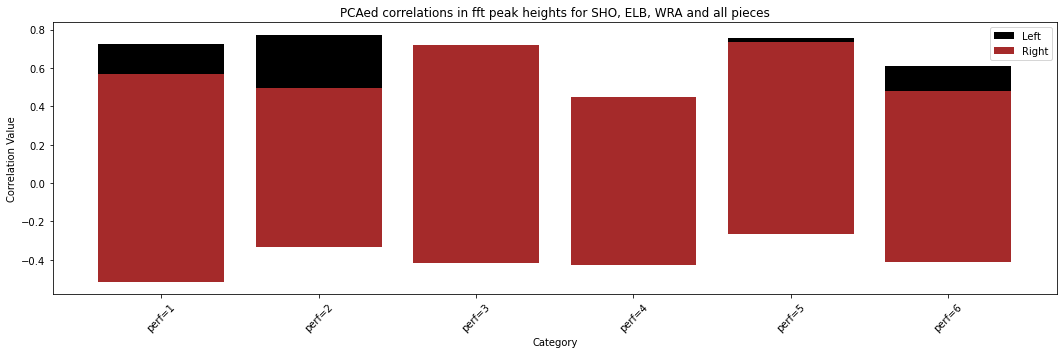

In [227]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

plt.figure(figsize=(18, 5))
for perf in [1,2,3,4,5,6]: #perf
    Ly1_subsetCol = Lycorr_matrix.filter(regex=f'^y{perf}')
    Ly1_subset = Ly1_subsetCol.loc[Lycorr_matrix.index.str.match(f'^y{perf}')]
    Ry1_subsetCol = Rycorr_matrix.filter(regex=f'^y{perf}')
    Ry1_subset = Ry1_subsetCol.loc[Rycorr_matrix.index.str.match(f'^y{perf}')]

    # PCA across all entries in subset
    x = f'{perf=}'
    Ly1_pca = pca.fit_transform(Ly1_subset).flatten()
    print(Ly1_pca)
    Ry1_pca = pca.fit_transform(Ry1_subset).flatten()
    plt.bar(x,Ly1_pca, color="black")
    plt.bar(x,Ry1_pca, color="brown")
plt.bar(x,Ly1_pca, color="black", label="Left")
plt.bar(x,Ry1_pca, color="brown", label="Right")
plt.title("PCAed correlations in fft peak heights for SHO, ELB, WRA and all pieces")
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Correlation Value')
plt.legend()
plt.show()